In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json  ~/.kaggle/
!kaggle datasets download -d usharengaraju/dynamically-generated-hate-speech-dataset

  0% 0.00/1.64M [00:00<?, ?B/s]
100% 1.64M/1.64M [00:00<00:00, 43.2MB/s]


In [2]:
!unzip /content/dynamically-generated-hate-speech-dataset.zip
!rm /content/dynamically-generated-hate-speech-dataset.zip

Archive:  /content/dynamically-generated-hate-speech-dataset.zip
  inflating: 2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv  
  inflating: 2020-12-31-DynamicallyGeneratedHateDataset-targets-v0.1.csv  


In [3]:
import os
import pandas as pd
import seaborn as sns

In [4]:
df = pd.read_csv("/content/2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv")
df

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm
...,...,...,...,...,...,...,...,...,...,...,...
40618,40736,9995,we should forcibly remove all the foreigners f...,hate,notgiven,True,0.86945,dynabench entry,1,train,cagnluiznm
40619,40737,9996,we should forcibly remove all the immigrants f...,hate,notgiven,True,0.50039,dynabench entry,1,train,cagnluiznm
40620,40738,9997,dalits are unworthy of the Gods love,hate,notgiven,True,0.97652,dynabench entry,1,train,cagnluiznm
40621,40739,9998,dalits are worthless,hate,notgiven,True,0.94326,dynabench entry,1,train,cagnluiznm


<Axes: xlabel='label', ylabel='count'>

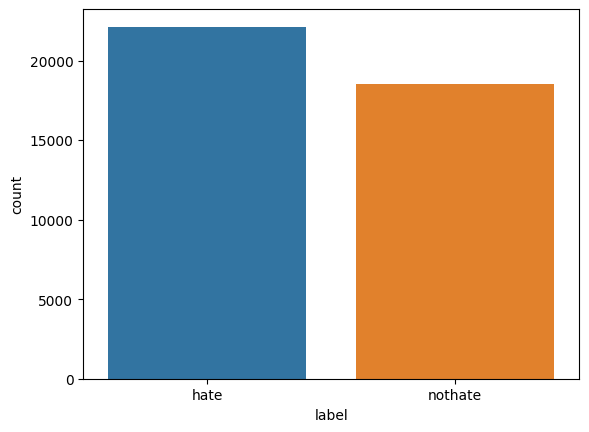

In [5]:
sns.countplot(x = 'label', data = df)

In [6]:
df.isnull().sum()

Unnamed: 0            0
id                    0
text                  0
label                 0
type                  0
model_wrong       14526
db.model_preds    14526
status                0
round                 0
split                 0
annotator             0
dtype: int64

In [7]:
df.drop(["id","type","model_wrong","db.model_preds","status","round","split","annotator","Unnamed: 0"],axis = 1,inplace = True)

In [8]:
df['label'].value_counts()

hate       22124
nothate    18499
Name: label, dtype: int64

In [9]:
df['label'].replace({"hate":1,"nothate":0},inplace = True)

In [10]:
df['label'].unique()

array([1, 0])

In [11]:
df.shape

(40623, 2)

In [12]:
df.head()

,text,label
0,It should be legal for a husband to rape his wife,1
1,dalits are lowlife scum,1
2,dalits are lowlives,1
3,It was a better world when women dare not ques...,1
4,I don't work this hard so that those immigrant...,1


In [13]:
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words("english"))

In [15]:
def clean_data(words):
  words = str(words).lower()
  words = re.sub('\[.*?\]', '', words)
  words = re.sub('https?://\S+|www\.\S+',"",words)
  words = re.sub("<.*?>+","",words)
  words = re.sub("[%s]" % re.escape(string.punctuation),"",words)
  words = re.sub("\n","",words)
  words = re.sub("\w*\d\w*","",words)
  words = [word for word in words.split(' ') if word not in stopword]
  words = " ".join(words)
  words = [stemmer.stem(word) for word in words.split(' ')]
  words = " ".join(words)
  return words

In [16]:
df['text'] = df['text'].apply(clean_data)

In [17]:
df.head()

,text,label
0,legal husband rape wife,1
1,dalit lowlif scum,1
2,dalit lowliv,1
3,better world women dare question men,1
4,dont work hard immigr take benefit,1


In [18]:
X = df['text']
y = df['label']

In [19]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42,test_size = 0.33)

In [20]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((27217,), (27217,), (13406,), (13406,))

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
print(sequences)
sequences_matrix = pad_sequences(sequences,maxlen = max_len)

[[4276, 5844, 120, 51, 2281, 666, 777, 89, 341, 2839, 177, 14, 207, 38, 1006, 207, 26, 10, 228, 13, 121], [31, 213, 821, 1, 265, 4], [2, 2195], [19, 2027], [342, 118, 58, 502, 127, 42, 8, 19, 35, 71, 7, 30, 46, 13, 29, 105, 9, 236, 359, 110, 515], [139, 3865, 479], [3, 1306, 3, 1378, 28, 4, 3, 1378], [242, 265, 20, 28, 1588, 712, 409], [290, 10, 48, 10, 2282], [26, 1237, 23, 205, 100, 5845, 985], [39, 8209, 966, 735, 3249, 832, 23, 3019, 1060, 1589, 92, 822, 2521, 1112, 616, 2840, 445, 4923, 8210, 23, 5846, 729, 114, 735, 103, 52], [791, 260, 94, 111, 446], [6, 417, 5], [17, 8, 589, 193, 62, 34, 83, 1, 34, 143, 42, 26, 47, 23, 282], [660, 152, 607, 207, 2665, 2028, 2109, 15, 428, 22, 132, 64, 2841, 191, 324, 833, 69], [16, 4, 1076, 7], [3020, 893, 2, 3866, 136, 46, 90], [556, 2196, 1730, 49, 65, 42, 157, 2110, 1211, 4277, 178, 10, 253, 8211, 329, 1731], [14, 3, 683], [128, 1152, 1281, 2399, 330, 1282, 191, 583, 446], [2, 14, 429], [600, 1416, 651, 3525, 597, 645], [684, 335, 84], [252,

In [23]:
sequences_matrix

array([[   0,    0,    0, ...,  228,   13,  121],
       [   0,    0,    0, ...,    1,  265,    4],
       [   0,    0,    0, ...,    0,    2, 2195],
       ...,
       [   0,    0,    0, ...,  134,  471,  480],
       [   0,    0,    0, ...,  550,  301,  167],
       [   0,    0,    0, ...,  109,   82,   94]], dtype=int32)

In [24]:
## Model
model = Sequential()
model.add(Embedding(max_words, 100, input_length = max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1,activation = "sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.compile(loss = "binary_crossentropy",optimizer = RMSprop(),metrics = ['accuracy'])

In [26]:
history = model.fit(sequences_matrix,y_train, batch_size = 32, epochs = 5, validation_split = 0.2)

Epoch 1/5
681/681 [==============================] - 454s 654ms/step - loss: 0.6285 - accuracy: 0.6382 - val_loss: 0.5810 - val_accuracy: 0.6848
Epoch 2/5
681/681 [==============================] - 439s 644ms/step - loss: 0.5505 - accuracy: 0.7201 - val_loss: 0.5581 - val_accuracy: 0.7111
Epoch 3/5
681/681 [==============================] - 438s 643ms/step - loss: 0.5108 - accuracy: 0.7495 - val_loss: 0.5361 - val_accuracy: 0.7250
Epoch 4/5
681/681 [==============================] - 441s 648ms/step - loss: 0.4785 - accuracy: 0.7727 - val_loss: 0.5404 - val_accuracy: 0.7318
Epoch 5/5
681/681 [==============================] - 444s 652ms/step - loss: 0.4522 - accuracy: 0.7866 - val_loss: 0.5267 - val_accuracy: 0.7340


In [27]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen = max_len)

In [28]:
acc = model.evaluate(test_sequences_matrix,y_test)

419/419 [==============================] - 38s 91ms/step - loss: 0.5449 - accuracy: 0.7284


In [29]:
pred = model.predict(test_sequences_matrix)
y_pred  = []
for prob in pred:
  if prob[0] < 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

419/419 [==============================] - 37s 88ms/step


In [30]:
print(confusion_matrix(y_test,y_pred))

[[3773 2372]
 [1269 5992]]


In [31]:
import pickle
with open("tokenizer.pickle","wb") as handle:
  pickle.dump(tokenizer,handle, protocol = pickle.HIGHEST_PROTOCOL)

In [32]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
import keras

load_model = keras.models.load_model("model.h5")
with open("tokenizer.pickle","rb") as handle:
  load_tokenizer = pickle.load(handle)

In [34]:
test = "Humans Are Idiot"
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

test =[clean_text(test)]
print(test)

Humans Are Idiot
humans are idiot
['human idiot']


In [35]:
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen = 300)
print(seq)

[[165, 186]]


In [36]:
pred = load_model.predict(padded)
print(pred)

1/1 [==============================] - 0s 296ms/step
[[0.38815343]]


In [37]:
if pred < 0.5:
  print("No Hate")
else:
  print("Hate")

No Hate
